# SETUP

In [1]:
import sys
sys.path.insert(0,'..')
from medzoo_imports import create_model, DiceLoss, Trainer
from os import listdir
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from data_generators.data_loader import SegmentationDataSet, sliding_window
import torch
from astropy.io import fits
import numpy as np
from astropy.visualization import ZScaleInterval, ImageNormalize
import matplotlib.pyplot as plt
import pandas as pd
import torch.backends.cudnn as cudnn
from matplotlib.cm import register_cmap


Properties of pre-trained model

In [2]:
batch_size=1
dataset_name="hi_data"
root = '../'
dim=(64, 64, 64)
nEpochs=10
classes=1
inChannels=1
terminal_show_freq=50
model='VNET'
opt='sgd'
log_dir='../runs/'
lr = 1e-2
dims = [128, 128, 64]
overlaps = [15, 20, 20]
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 2}

save = ('../saved_models/' + model + '_checkpoints/' + model + '_', dataset_name)[0]

Load pre-trained model

In [175]:
class argsclass:
    def __init__(self, model, opt, lr, inChannels, classes, pretrained):
        self.model = model
        self.opt=opt
        self.lr=lr
        self.inChannels=1
        self.classes=1
        self.cuda = False
        self.pretrained = pretrained
        self.dataset_name = 'hi_source'
        self.save = './inference_checkpoints/' + self.model + '_checkpoints/' + self.model + '_' + self.dataset_name
args = argsclass('VNET', 'adam', 1e-2, 1, 1, "../saved_models/VNET_checkpoints/VNET_/VNET__BEST.pth")
model, optimizer = create_model(args)
criterion = DiceLoss(classes=args.classes)
model.restore_checkpoint(args.pretrained)

Building Model . . . . . . . .VNET
VNET Number of params: 45599926


3

In [103]:
train_df = pd.read_csv("../saved_models/VNET_checkpoints/VNET_/train.csv", header=None, sep=" ", names=["skip", "epoch", "loss", "dsc"])
val_df = pd.read_csv("../saved_models/VNET_checkpoints/VNET_/val.csv", header=None, sep=" ", names=["skip", "epoch", "loss", "dsc"])

In [105]:
val_df["loss"] = val_df.loss.str.split(":", expand=True)[1]
train_df["loss"] = train_df.loss.str.split(":", expand=True)[1]
val_df["dsc"] = val_df.dsc.str.split(":", expand=True)[1]
train_df["dsc"] = train_df.dsc.str.split(":", expand=True)[1]
train_df = train_df[['epoch', 'loss', 'dsc']]
val_df = val_df[['epoch', 'loss', 'dsc']]

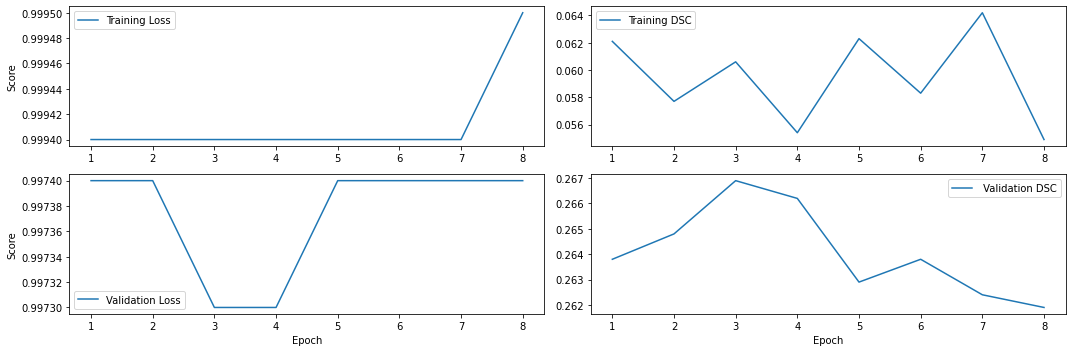

In [106]:
fig, axes = plt.subplots(2, 2, figsize = (15, 5))

axes[0][0].plot(train_df.epoch, train_df.loss.astype(float), label="Training Loss")
axes[0][1].plot(train_df.epoch, train_df.dsc.astype(float), label="Training DSC")
axes[1][0].plot(val_df.epoch, val_df.loss.astype(float), label="Validation Loss")
axes[1][1].plot(val_df.epoch, val_df.dsc.astype(float), label=" Validation DSC")

axes[1][0].set_xlabel("Epoch")
axes[1][1].set_xlabel("Epoch")
axes[0][0].set_ylabel("Score")
axes[1][0].set_ylabel("Score")
axes[0][0].legend()
axes[1][0].legend()
axes[1][1].legend()
axes[0][1].legend()
fig.tight_layout()

Load the test subcubes

In [171]:
def prepare_data(data):
    interval = ZScaleInterval()
    return interval(np.nan_to_num(np.moveaxis(data, 0, 2)))

noisefree_7.fits
(tensor(1.), array([0.], dtype=float32))


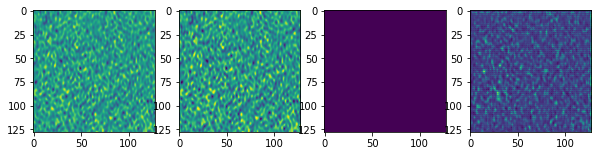

noisefree_6.fits
(tensor(1.), array([0.], dtype=float32))


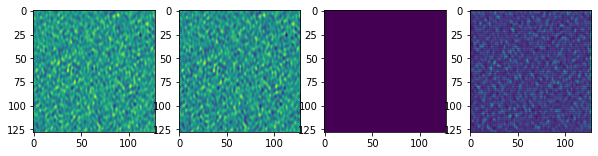

noisefree_1.fits
(tensor(0.9454), array([0.05463746], dtype=float32))


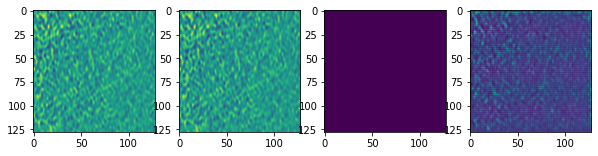

noisefree_0.fits
(tensor(1.), array([0.], dtype=float32))


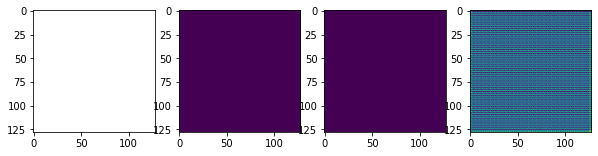

noisefree_3.fits
(tensor(1.), array([0.], dtype=float32))


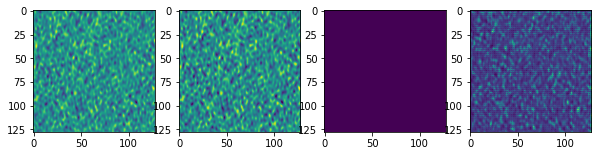

noisefree_2.fits
(tensor(0.9907), array([0.00929345], dtype=float32))


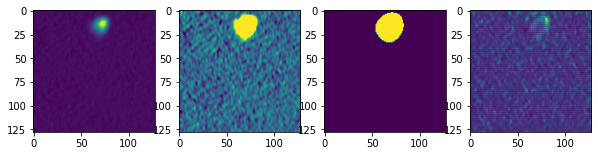

noisefree_5.fits
(tensor(1.), array([0.], dtype=float32))


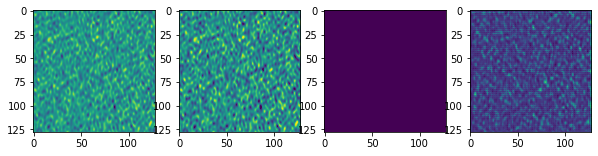

noisefree_9.fits
(tensor(1.), array([0.], dtype=float32))


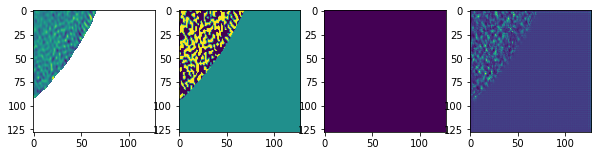

noisefree_8.fits
(tensor(1.), array([0.], dtype=float32))


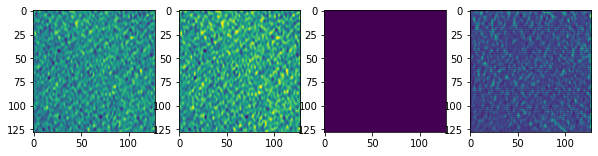

noisefree_4.fits
(tensor(1.), array([0.], dtype=float32))


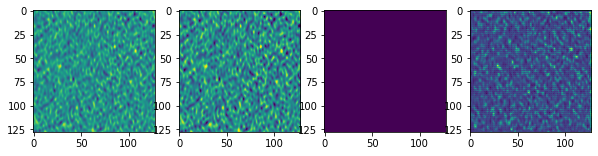

In [178]:
model.eval()
for file in listdir("../data/testing/Input/"):
    print(file)
    orig_data = fits.getdata("../data/testing/Input/"+file)[:64, :128, :128]
    prepared_data = prepare_data(orig_data)
    realseg_data = fits.getdata("../data/testing/Target/mask_"+file.split("_")[-1])[:64, :128, :128]
    
    data_loader_tensor = torch.FloatTensor(prepared_data.astype(np.float32)).unsqueeze(0)[None, ...]
    with torch.no_grad():
        out_cube = model.inference(data_loader_tensor)
        
    loss_dice, per_ch_score = criterion(out_cube, torch.FloatTensor(np.moveaxis(realseg_data, 0, 2).astype(np.float32)).unsqueeze(0)[None, ...])
    print(loss_dice)
    fig, axes = plt.subplots(1, 4, figsize=(10, 10))
    axes[0].imshow(orig_data[1])
    axes[1].imshow(prepared_data[..., 1])
    axes[2].imshow(realseg_data[1])
    axes[3].imshow(out_cube.squeeze()[..., 1])
    plt.show()

In [ ]:
model.eval()
file = "noisefree_2.fits"
print(file)
orig_data = fits.getdata("../data/testing/Input/"+file)[:64, :128, :128]
prepared_data = prepare_data(orig_data)
realseg_data = fits.getdata("../data/testing/Target/mask_"+file.split("_")[-1])[:64, :128, :128]

data_loader_tensor = torch.FloatTensor(prepared_data.astype(np.float32)).unsqueeze(0)[None, ...]
with torch.no_grad():
    out_cube = model.inference(data_loader_tensor)

loss_dice, per_ch_score = criterion(out_cube, torch.FloatTensor(np.moveaxis(realseg_data, 0, 2).astype(np.float32)).unsqueeze(0)[None, ...])
print(loss_dice)

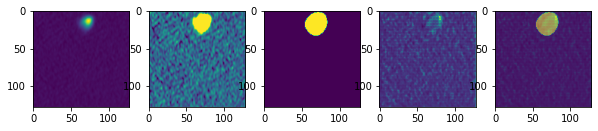

In [188]:
fig, axes = plt.subplots(1, 5, figsize=(10, 10))
axes[0].imshow(orig_data[1])
axes[1].imshow(prepared_data[..., 1])
axes[2].imshow(realseg_data[1])
axes[3].imshow(out_cube.squeeze()[..., 1])
axes[4].imshow(realseg_data[1])
axes[4].imshow(out_cube.squeeze()[..., 1], alpha=0.5)
plt.show()